In [1]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train = pd.read_csv("data/titanic/train.csv")
test = pd.read_csv("data/titanic/test.csv")
IDtest = test["PassengerId"]

In [3]:
# 이상치 탐지

def detect_outliers(df,n,features):
    """
    함수의 데이터 프레임 df를 취하고 인덱스 목록을 반환합니다.
    """
    outlier_indices = []
    
    # 열에 대해 반복
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Feature에 대한 이상 값 인덱스 목록
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # col에 대해 발견된 이상치 인덱스를 이상치 인덱스 목록에 추가 
        outlier_indices.extend(outlier_list_col)
        
    # 2개 이상의 이상값을 포함하는 관측값 선택
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# Age, SibSp, Parch 및 Fare에서 이상값 감지
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

* 이상치는 예측에 극적인 영향을 미칠 수 있기 때문에 (특히 회귀 문제의 경우) 이를 관리하기로 결정했습니다.

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


### 이상치 제거

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 범주형 변환 중에 동일한 수의 기능을 얻기 위해 훈련 데이터 세트와 테스트 데이터 세트를 결합

In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 결측치 확인

In [7]:
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Feature analysis

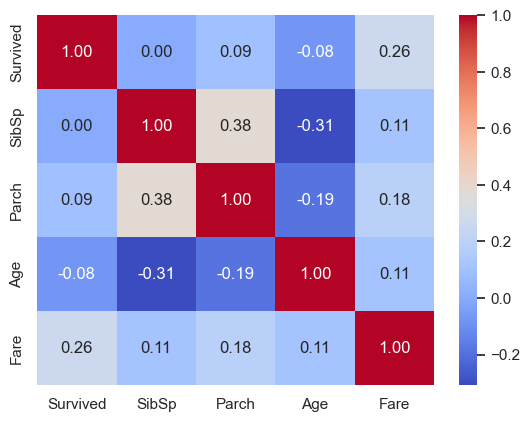

In [10]:
# Feature간 상관관계 확인
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

요금(Fare)만이 생존확률(Survived)와 유의한 상관관계가 있는 것으로 보인다.


* 다른 Feature가 유용하지 않다는 의미는 아님

### SibSP

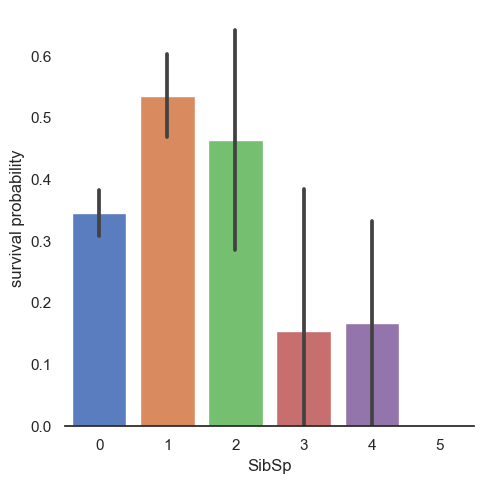

In [11]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar" , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

형제/배우자가 많은 승객은 생존 가능성이 낮아 보인다.


* Single 탑승자또는 two other persons가 가장 많은 생존확률을 보인다.

### Parch

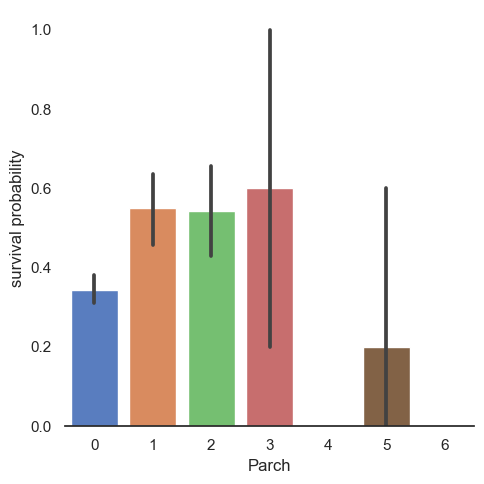

In [12]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

소가족은 싱글, 중형(3,4) 및 대가족(5,6)보다 더 많은 생존 기회가 있다.

### Age

C:\Users\junmo\AppData\Local\Temp\ipykernel_4912\1732533048.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
C:\Users\junmo\AppData\Local\Temp\ipykernel_4912\1732533048.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


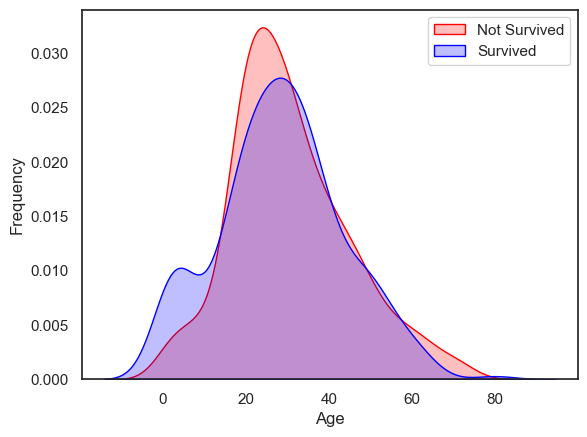

In [13]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

### Fare

In [14]:
dataset["Fare"].isnull().sum()

1

In [15]:
# 중앙값으로 채워주기

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

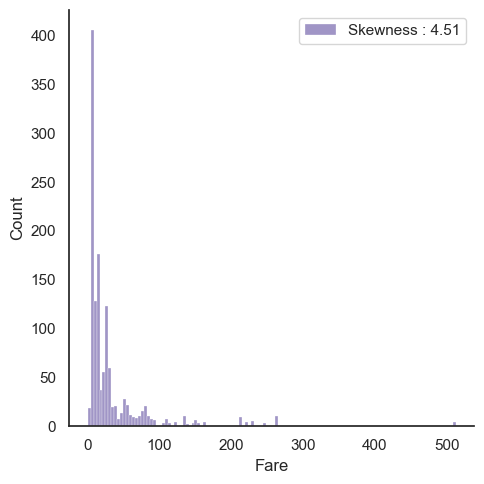

In [16]:
sns.displot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
plt.legend(loc = "best")

한쪽으로 분포가 많이 치우친걸 확인할 수 있다. 


이런경우 로그변환을 통해 완화시킬 수 있다.

In [17]:
dataset["Fare_log"] = np.log(dataset["Fare"])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


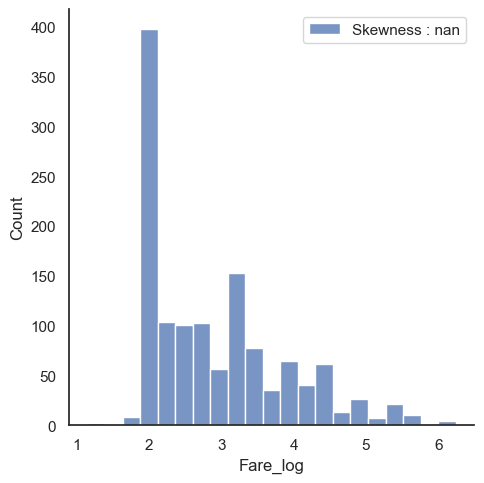

In [18]:
sns.displot(dataset["Fare_log"], color="b", label="Skewness : %.2f"%(dataset["Fare_log"].skew()))
plt.legend(loc = "best")

# Sex

Text(0, 0.5, 'Survival Probability')

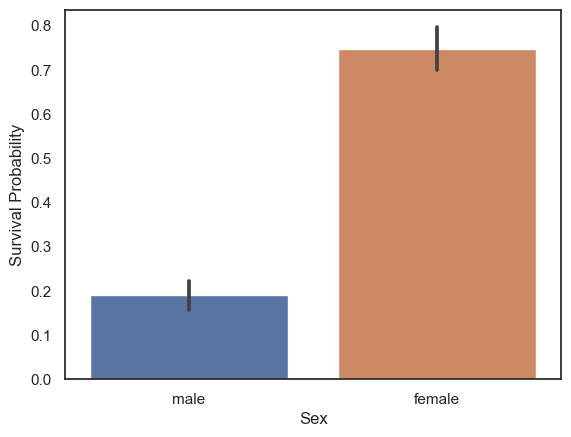

In [19]:
sns.barplot(x = "Sex", y = "Survived", data = train)
plt.ylabel("Survival Probability")

In [20]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 생존률 이 급격하게 낮은 것을 확인할 수 있다.

따라서 성별은 생존률에 대한 중요한 변수가 될것이다.

### Pclass

Text(12.444444444444445, 0.5, 'survival probability')

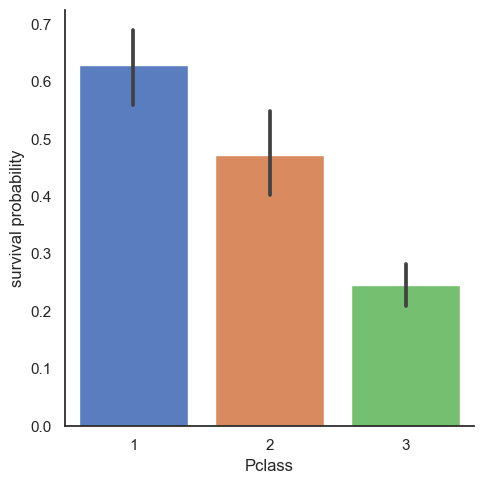

In [21]:
sns.catplot(x="Pclass",y="Survived",data=train,kind="bar", 
palette = "muted")
plt.ylabel("survival probability")

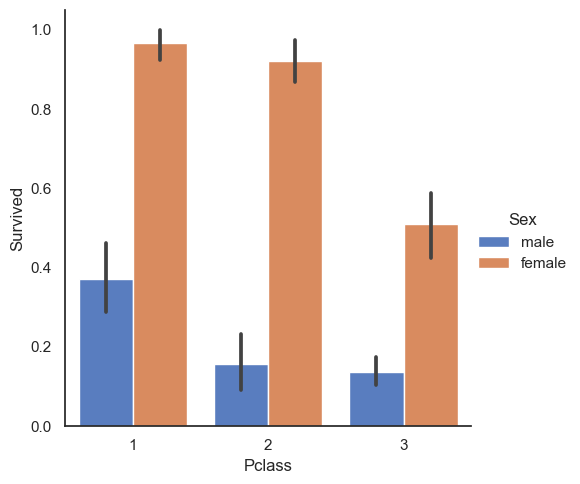

In [22]:
# Pclass vs Survived by Sex

sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                    kind="bar", palette="muted")

### Embarked

In [23]:
dataset["Embarked"].isnull().sum()

2

In [24]:
# Embarked의 결측치는 최빈값인 "S"로 채워줌
dataset["Embarked"] = dataset["Embarked"].fillna("S")

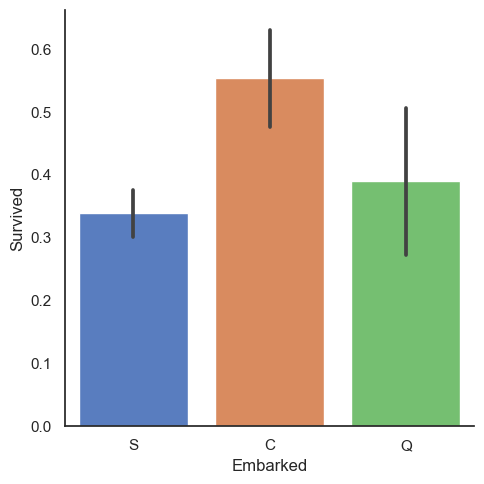

In [25]:
sns.catplot(x="Embarked", y="Survived",  data=train,
                    kind="bar", palette="muted")

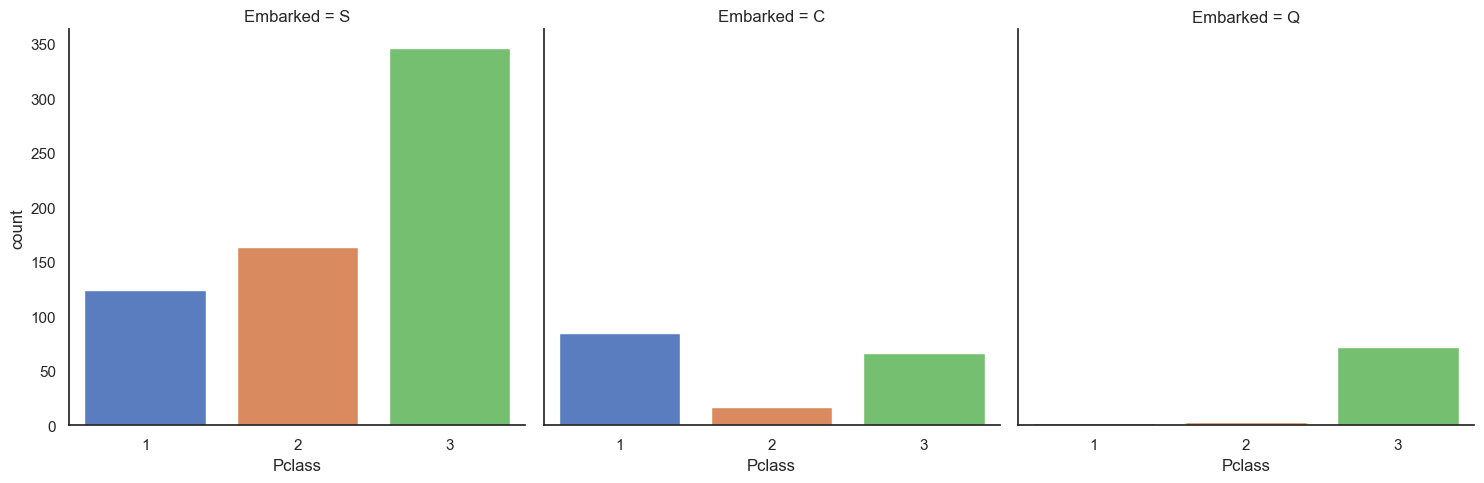

In [26]:
sns.catplot(x = "Pclass", col="Embarked",  data=train,
                 kind="count", palette="muted")

In [27]:
# 결측치 채우기
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Users\junmo\AppData\Local\Temp\ipykernel_4912\1153045495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\junmo\AppData\Local\Temp\ipykernel_4912\1153045495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_med


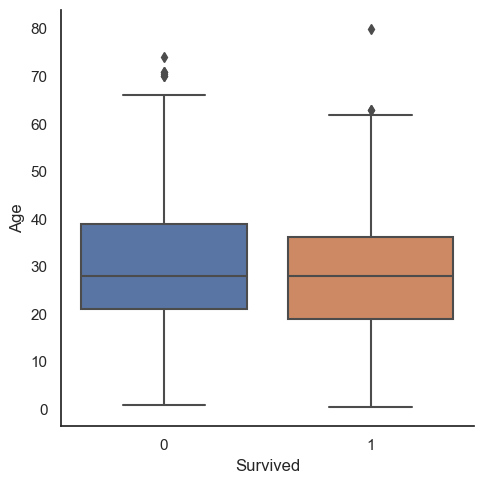

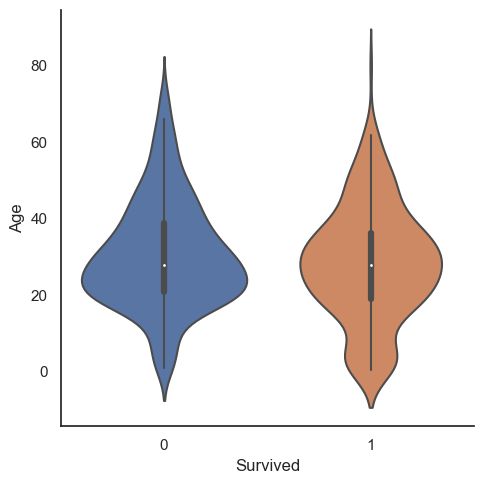

In [28]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

생존한 하위 집단과 생존하지 않은 하위 집단에서 연령의 중앙값 사이에는 차이가 없다.

그러나 생존한 승객의 바이올린 플롯에서 우리는 여전히 아주 어린 승객의 생존율이 더 높다는 것을 알 수 있다

# Feature engineering


### Name/Title

In [29]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [30]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

<AxesSubplot:xlabel='Title', ylabel='count'>

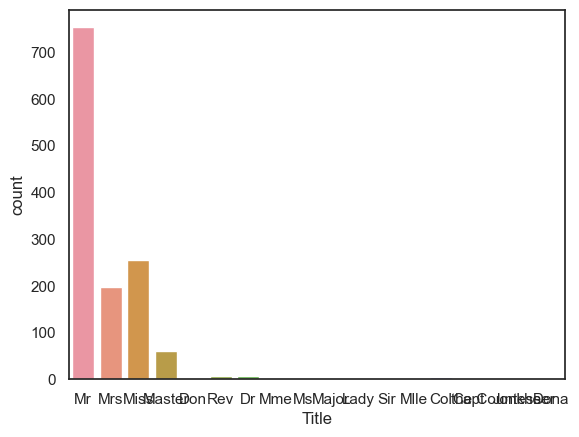

In [31]:
sns.countplot(x = "Title", data = dataset)

In [32]:
# Title을 범주형 값으로 변환 

dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

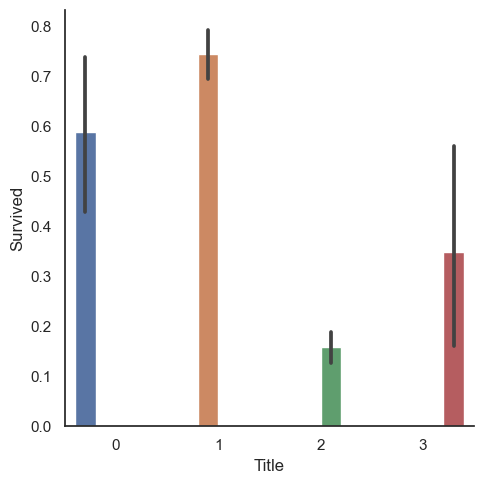

In [33]:
sns.catplot(x = "Title", y = "Survived", data = dataset, kind = "bar", hue = "Title")

In [34]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

# Family size 생성

In [35]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1 # 자기자신도 더하기에 +1 

C:\Users\junmo\AppData\Roaming\Python\Python39\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Text(12.444444444444445, 0.5, 'Survival Probability')

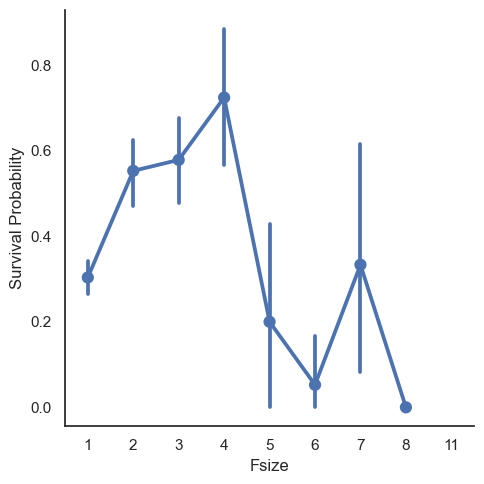

In [36]:
sns.catplot(x="Fsize",y="Survived",data = dataset, kind = "point")
plt.ylabel("Survival Probability")


In [37]:
# 새로운 파생변수 생성
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

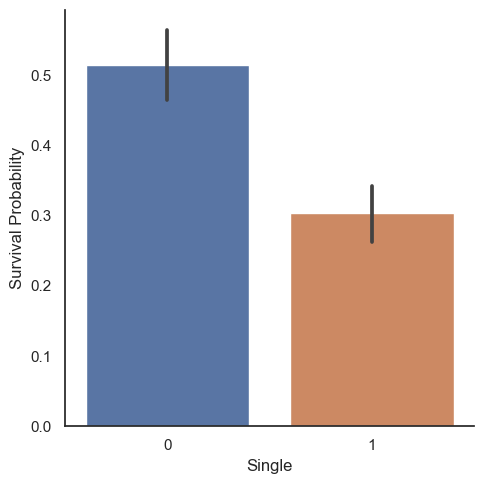

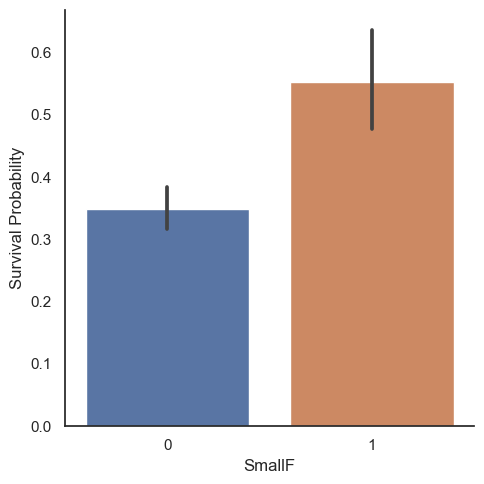

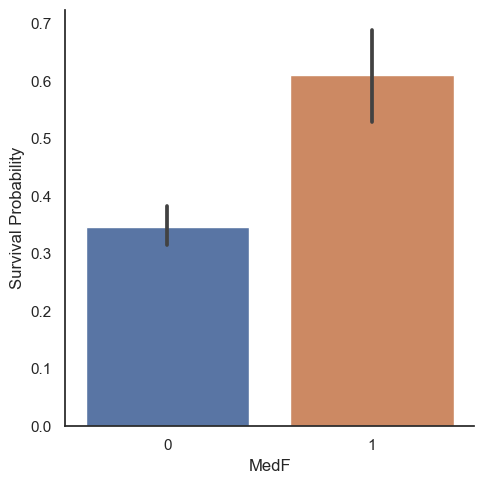

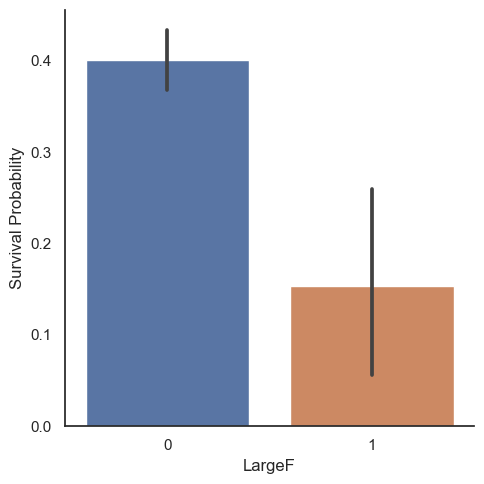

In [38]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [39]:
# get_dummies로 인코딩

dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [40]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,female,35.0,1,0,113803,53.1000,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,...,0,0,0,0,0,1,0,0,0,1


### Cabin

In [41]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [42]:
dataset["Cabin"].describe()


count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [43]:
dataset["Cabin"].isnull().sum()


1007

In [44]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()


1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [45]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [46]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### Ticket

In [47]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [48]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [49]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [50]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [51]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)
dataset.drop(labels = ["Fare_log"], axis = 1, inplace = True)

In [52]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,male,22.0,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,female,38.0,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,female,26.0,0,0,7.9250,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,female,35.0,1,0,53.1000,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,male,35.0,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [53]:
dataset["Sex"] = dataset["Sex"].replace("male",0)
dataset["Sex"] = dataset["Sex"].replace("female",1)

In [54]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,7.9250,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,53.1000,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# MODELING